In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from pipetorch import DFrame
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

ingr = pd.read_csv('/data/foodboost/ingredients.csv', index_col=0)
nutr = pd.read_csv('/data/foodboost/nutritions.csv', index_col=0)
recp = pd.read_csv('/data/foodboost/recipes.csv', index_col=0)
tags = pd.read_csv('/data/foodboost/tags.csv', index_col=0)

tags
#p_nutr = DFrame.read_from_kaggle('/data/foodboost/nutritions.csv', index_col=0, header=0)

,recipe,tag
0,Kruidnoten met choco-discodip,hollands
1,Kruidnoten met choco-discodip,gebak
2,Kruidnoten met choco-discodip,gebak
3,Kruidnoten met choco-discodip,sinterklaas
4,Kruidnoten met choco-discodip,sinterklaasavond
...,...,...
46035,Pittige truffels,nagerecht
46036,Biefstuk met rodewijnsaus en ham,snel
46037,Biefstuk met rodewijnsaus en ham,mediterraan
46038,Biefstuk met rodewijnsaus en ham,hoofdgerecht


In [2]:
nutr_cal = nutr.loc[nutr['nutrition'] == 'energie']
nutr_eiw = nutr.loc[nutr['nutrition'] == 'eiwit']
tags['jointags'] = tags[['recipe', 'tag']].groupby(['recipe'])['tag'].transform(lambda x: ','.join(x))
tags_join = tags[['recipe', 'jointags']]
tags_join.drop_duplicates(inplace=True, ignore_index=True)
tags_join

/tmp/ipykernel_31069/3518850406.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tags_join.drop_duplicates(inplace=True, ignore_index=True)


,recipe,jointags
0,Kruidnoten met choco-discodip,"hollands,gebak,gebak,sinterklaas,sinterklaasavond"
1,Kruidnoten in marsepein,"hollands,gebak,gebak,sinterklaas,sinterklaasavond"
2,Kruidnoten met chocodips,"hollands,gebak,gebak,sinterklaas,sinterklaasavond"
3,Pepernotentaart met marsepeinstrik,"oven,hollands,gebak,gebak,sinterklaas,sinterkl..."
4,Perencake,"vooraf te maken,oven,gebak,gebak"
...,...,...
8700,Paddenstoelen en courgettegratin,"oven,bijgerecht"
8701,Peren-amandelcoupe,"mediterraan,nagerecht"
8702,Ceviche met sint-jakobsschelpen,voorgerecht
8703,Pittige truffels,"glutenvrij,oven,gebak,gebak,nagerecht"


In [3]:
nutr_new = pd.merge(nutr_cal, nutr_eiw[['recipe', 'value']], how = 'outer', left_on = 'recipe', right_on = 'recipe')
nutr_new.fillna('0 g', inplace=True)
nutr_new = pd.merge(nutr_new, tags_join[['recipe', 'jointags']], how = 'outer', left_on = 'recipe', right_on = 'recipe')
nutr_new.fillna('*no tags', inplace=True)
nutr_new['calorieën'] = nutr_new['value_x'].map(lambda x: int(x.rstrip(' kcal')))
nutr_new['eiwitten'] = nutr_new['value_y'].map(lambda x: float(x.rstrip(' g')))
nutr_new = nutr_new.drop(columns=['value_x', 'value_y', 'nutrition'])
nutr_new

,recipe,jointags,calorieën,eiwitten
0,Kruidnoten met choco-discodip,"hollands,gebak,gebak,sinterklaas,sinterklaasavond",260,3.0
1,Kruidnoten in marsepein,"hollands,gebak,gebak,sinterklaas,sinterklaasavond",265,3.0
2,Kruidnoten met chocodips,"hollands,gebak,gebak,sinterklaas,sinterklaasavond",335,5.0
3,Pepernotentaart met marsepeinstrik,"oven,hollands,gebak,gebak,sinterklaas,sinterkl...",560,5.0
4,Perencake,"vooraf te maken,oven,gebak,gebak",265,5.0
...,...,...,...,...
8701,Paddenstoelen en courgettegratin,"oven,bijgerecht",285,11.0
8702,Peren-amandelcoupe,"mediterraan,nagerecht",160,1.0
8703,Ceviche met sint-jakobsschelpen,voorgerecht,210,14.0
8704,Pittige truffels,"glutenvrij,oven,gebak,gebak,nagerecht",65,1.0


In [4]:
nutr_new_lunch = nutr_new[nutr_new['jointags'].str.contains('lunch')]
nutr_new_diner = nutr_new[nutr_new['jointags'].str.contains('diner')]
nutr_new_hoofdg = nutr_new[nutr_new['jointags'].str.contains('hoofdgerecht')]
nutr_new_avond = pd.concat([nutr_new_diner,nutr_new_hoofdg],axis=0)

In [5]:
nutr_allcombo = nutr_new_lunch.merge(nutr_new_avond, how = 'cross')
nutr_allcombo = nutr_allcombo.drop(['jointags_x', 'jointags_y','eiwitten_x', 'eiwitten_y'], axis=1)
nutr_allcombo.rename(columns={'recipe_x': 'lunch_recipe', 'calorieën_x': 'lunch_kcal', 'recipe_y': 'diner_recipe', 'calorieën_y': 'diner_kcal'}, inplace=True)
nutr_allcombo['som_kcal'] = nutr_allcombo['lunch_kcal'] + nutr_allcombo['diner_kcal']

In [6]:
nutr_allcombo

,lunch_recipe,lunch_kcal,diner_recipe,diner_kcal,som_kcal
0,"Wortelwraps met kikkererwten, paprika en tzatz...",280,Viscurry met spinazie en kikkererwten,305,585
1,"Wortelwraps met kikkererwten, paprika en tzatz...",280,Thaise scholspiesjes met kruidige rijst en wor...,495,775
2,"Wortelwraps met kikkererwten, paprika en tzatz...",280,Gebakken scholfilet met lauwwarme rijstsalade,550,830
3,"Wortelwraps met kikkererwten, paprika en tzatz...",280,Gegrilde scholfilet met couscous-venkelsalade,585,865
4,"Wortelwraps met kikkererwten, paprika en tzatz...",280,Gnocchi met spek en pecorino,330,610
...,...,...,...,...,...
3335730,Kalkoensandwich met dragonmayonaise,544,Romige spaghetti met zalmreepjes,610,1154
3335731,Kalkoensandwich met dragonmayonaise,544,Tijmballetjes met puree,590,1134
3335732,Kalkoensandwich met dragonmayonaise,544,Romige mosselen met dille,570,1114
3335733,Kalkoensandwich met dragonmayonaise,544,Mosselen op z'n Thais,610,1154


In [7]:
nutr_mul = nutr_allcombo[['lunch_kcal', 'diner_kcal', 'som_kcal']]
y=nutr_mul[['som_kcal']]
x1=nutr_mul[['lunch_kcal']]
x2=nutr_mul[['diner_kcal']]

In [21]:
train_x1, test_x1, train_x2, test_x2, train_y, test_y = train_test_split(x1,x2,y, test_size=0.0001, random_state=20)

In [22]:
test_y

,som_kcal
2842023,1290
2914745,1190
2187563,1190
1813693,1055
107372,1025
...,...
1168098,1365
941241,905
663906,940
1809590,705


(0.0, 1200.0)

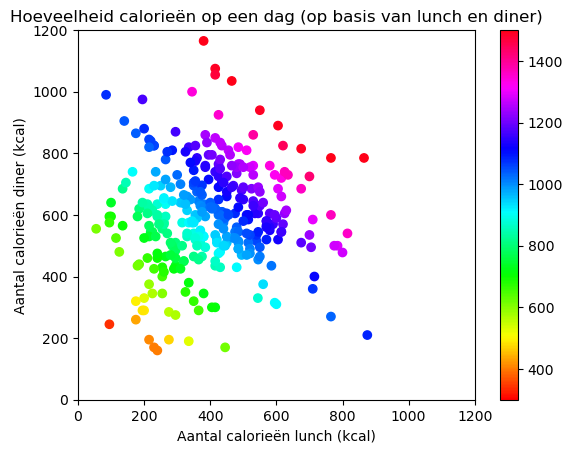

In [23]:
fig, ax = plt.subplots()
scat = ax.scatter(x = test_x1,y = test_x2, c=test_y['som_kcal'], marker='o',vmin = 300, vmax =1500, cmap='hsv')
fig.colorbar(scat)
plt.title('Hoeveelheid calorieën op een dag (op basis van lunch en diner)')
plt.xlabel('Aantal calorieën lunch (kcal)')
plt.ylabel('Aantal calorieën diner (kcal)')
plt.xlim(0,1200)
plt.ylim(0,1200)


3.9278869671308366e-12